# Model for in game win probability
Used as a feature in the other models of the monte carlo simulation

In [4]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
import shap
import cfbd
from sklearn.metrics import (
    log_loss, 
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import numpy as np
from optuna.samplers import TPESampler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [5]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [6]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('t_ds', 'tds'))
    return cols_new

In [7]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in range(2012, 2025): # Adjusted to include 2012 for rolling window
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2012.parquet from cached data
Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo,start_date
0,322432710,2012,1,regular,True,False,3746.0,2710,Western Illinois,MVFC,fcs,23.0,NaN,2086,Butler,Pioneer,fcs,15.0,NaN,NaT
1,322432117,2012,1,regular,True,False,3786.0,2117,Central Michigan,Mid-American,fbs,38.0,NaN,2546,Southeast Missouri State,OVC,fcs,27.0,NaN,NaT
2,322432050,2012,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,37.0,1299.0,2199,Eastern Michigan,Mid-American,fbs,26.0,1231.0,NaT
3,322432006,2012,1,regular,True,False,3768.0,2006,Akron,Mid-American,fbs,14.0,997.0,2116,UCF,Conference USA,fbs,56.0,1559.0,NaT
4,322430238,2012,1,regular,True,False,3973.0,238,Vanderbilt,SEC,fbs,13.0,1573.0,2579,South Carolina,SEC,fbs,17.0,1743.0,NaT


In [8]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in range(2012, 2025):  # Adjusted to include 2012 for rolling window
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.columns = plays.columns.str.replace('t_ds', 'tds', regex=False)
plays.head()

Reading ../data/plays/2012.parquet from cached data
Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_65194/2545760028.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,322450221037,32245022104,322450221,4,1,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,1,NaN,NaN,92,92,1,10,2,False,Rush,"Jamaine Cook rush for 2 yards to the YngSt 10,...",-0.207100,2,47
1,322450221048,32245022104,322450221,4,11,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,36,36,2,4,0,False,Rush,"Kurt Hess rush for no gain to the Pitt 36, tac...",-0.903926,15,0
2,322450221044,32245022104,322450221,4,7,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,59,59,1,10,0,False,Pass Incompletion,"Kurt Hess pass incomplete to Christian Bryan, ...",-1.138786,15,0
3,322450221045,32245022104,322450221,4,8,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,59,59,2,10,5,False,Pass Completion,Kurt Hess pass complete to Marcel Caver for 5 ...,0.068045,15,0
4,322450221041,32245022104,322450221,4,5,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,1,NaN,NaN,73,73,2,8,0,False,Pass Incompletion,"Kurt Hess pass incomplete to Christian Bryan, ...",-0.478808,2,47


In [9]:
elos = []
for year in range(2012, 2025):  # Adjusted to include 2012 for rolling window
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'season_type', 'team_id'], keep='first')
elo.head()

,season,week,season_type,team_id,team,division,elo
0,2012,1,regular,2,Auburn,fbs,2746.814245
1,2012,2,regular,2,Auburn,fbs,2682.892552
2,2012,3,regular,2,Auburn,fbs,2586.052374
3,2012,4,regular,2,Auburn,fbs,2588.228228
4,2012,6,regular,2,Auburn,fbs,2580.160704


# Data Engineering

In [35]:
games.head()

,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo,start_date
0,322432710,2012,1,regular,True,False,3746.0,2710,Western Illinois,MVFC,fcs,23.0,NaN,2086,Butler,Pioneer,fcs,15.0,NaN,NaT
1,322432117,2012,1,regular,True,False,3786.0,2117,Central Michigan,Mid-American,fbs,38.0,NaN,2546,Southeast Missouri State,OVC,fcs,27.0,NaN,NaT
2,322432050,2012,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,37.0,1299.0,2199,Eastern Michigan,Mid-American,fbs,26.0,1231.0,NaT
3,322432006,2012,1,regular,True,False,3768.0,2006,Akron,Mid-American,fbs,14.0,997.0,2116,UCF,Conference USA,fbs,56.0,1559.0,NaT
4,322430238,2012,1,regular,True,False,3973.0,238,Vanderbilt,SEC,fbs,13.0,1573.0,2579,South Carolina,SEC,fbs,17.0,1743.0,NaT


In [ ]:
play_cols = ['game_id', 'offense', 'offense_score', 'defense', 'defense_score', 
    'period', 'offense_timeouts', 'defense_timeouts', 'yardline', 
    'yards_to_goal', 'down', 'distance', 'play_type', 'play_text',
    'clock_minutes', 'clock_seconds']
play_types = [
    'Rush'
    'Pass Incompletion', 'Interception',
    'Pass Completion','Punt', 'Pass Interception',
    'Field Goal Good', 'Sack',
    'Field Goal Missed', 'Safety', 'Pass',
    'Pass Reception',
    'Passing Touchdown', 'Pass Interception Return',
    'Fumble Recovery (Own)', 'Rushing Touchdown',
    'Fumble Recovery (Opponent)', 'Blocked Field Goal',
    'Punt Return Touchdown',
    'Interception Return Touchdown',
    'Blocked Punt', 'Fumble Return Touchdown',
    'Blocked Punt Touchdown',
    'Missed Field Goal Return', 'Blocked Field Goal Touchdown',
    'Missed Field Goal Return Touchdown'
]
final_cols = ['game_id', 'period', 'is_home_team', 'offense_timeouts', 'defense_timeouts',
    'yards_to_goal', 'down', 'distance', 'offense_elo',
    'defense_elo', 'score_diff', 'elo_diff', 'pct_game_played', 'diff_time_ratio',
    'tie_score', 'close_score', 'late_game_close_score',
    'late_game_tie_score', 'down_x_distance',
    'outcome', ]

overtime_game_ids = plays.query('period > 4')['game_id'].unique()

play_attempts = (
    games[['id', 'season', 'week', 'season_type', 'home_team', 'home_points', 'away_team', 
        'away_points','neutral_site']]
        .rename(columns={'id': 'game_id'})
    .merge(
        plays[play_cols],
        on=['game_id'],
        how='left'
    )
    .query('play_type in @play_types')
    .query('0 < yards_to_goal < 100 and 0 < distance <= 40 and '
        '0 <= offense_timeouts <= 3 and 0 <= defense_timeouts <= 3 and '
        '0 <= clock_minutes <= 15 and 0 <= clock_seconds < 59')
    .merge(
        elo[['season', 'week', 'season_type', 'team', 'elo']]
            .rename(columns={'team': 'offense', 'elo': 'offense_elo'}),
        on=['season', 'week', 'season_type', 'offense'],
        how='left',
    )
    .merge(
        elo[['season', 'week', 'season_type', 'team', 'elo']]
            .rename(columns={'team': 'defense', 'elo': 'defense_elo'}),
        on=['season', 'week', 'season_type', 'defense'],
        how='left'
    )
    .assign(
        score_diff = lambda x: x['offense_score'] - x['defense_score'],
        elo_diff = lambda x: x['offense_elo'] - x['defense_elo'],
        is_home_team = lambda x: np.where(
            x.neutral_site == True,
            0,
            np.where(
                x.home_team == x.offense,
                1,
                -1
            )
        ),
        seconds_remaining = lambda x: (
            (4 * 15 * 60) - # total game time in seconds
            ((x['period'] - 1) * 15 * 60) - # elapsed quarters in seconds
            (15 * 60 - (x['clock_minutes'] * 60 + x['clock_seconds'])) 
        ),
        tie_score = lambda x: np.where(
            x.offense_score == x.defense_score,
            1,
            0
        ),
        close_score = lambda x: np.where(
            abs(x.offense_score - x.defense_score) <= 7,
            1,
            0
        ),
        late_game_close_score = lambda x: np.where(
            (x.seconds_remaining <= 60) & (abs(x.offense_score - x.defense_score) <= 7),
            1,
            0
        ),
        late_game_tie_score = lambda x: np.where(
            (x.seconds_remaining <= 60) & (x.tie_score == 1),
            1,
            0
        ),
        down_x_distance = lambda x: x['down'] * x['distance'],
        final_score_diff = lambda x: np.where(
            x.home_team == x.offense,
            x.home_points - x.away_points,
            x.away_points - x.home_points
        ),
        outcome = lambda x: np.where(
            x.game_id.isin(overtime_game_ids),
            1,
            np.where(
                x.home_team == x.offense,
                np.where(x.home_points > x.away_points, 2, 0),
                np.where(x.away_points > x.home_points, 2, 0)
            )
        ),
        
    )
    .assign(
        pct_game_played = lambda x: (4 * 15 * 60 - x['seconds_remaining']) / (4 * 15 * 60),
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['seconds_remaining']) / 3600),
    )
    .query('0<= pct_game_played <= 1 and final_score_diff != 0 and outcome.notna() and '
        'final_score_diff.notna()')
    [final_cols]
    .reset_index(drop=True)
)

play_attempts.head()

,game_id,period,is_home_team,offense_timeouts,defense_timeouts,yards_to_goal,down,distance,offense_elo,defense_elo,score_diff,elo_diff,pct_game_played,diff_time_ratio,tie_score,close_score,late_game_close_score,late_game_tie_score,down_x_distance,outcome
0,332412309,3.0,1,3.0,2.0,51.0,3.0,7.0,1954.443118,1553.191164,-3.0,401.251954,0.626389,-36.751088,0,1,0,0,21.0,2
1,332412309,3.0,1,2.0,2.0,45.0,3.0,12.0,1954.443118,1553.191164,-3.0,401.251954,0.677500,-45.087827,0,1,0,0,36.0,2
2,332412309,2.0,1,2.0,3.0,65.0,1.0,10.0,1954.443118,1553.191164,4.0,401.251954,0.453611,24.550662,0,1,0,0,10.0,2
3,332412309,2.0,1,2.0,3.0,79.0,2.0,9.0,1954.443118,1553.191164,4.0,401.251954,0.453611,24.550662,0,1,0,0,18.0,2
4,332412309,2.0,1,2.0,3.0,59.0,4.0,4.0,1954.443118,1553.191164,4.0,401.251954,0.453611,24.550662,0,1,0,0,16.0,2


In [61]:
for i in [0,1,2]:
    print(f'Unique games in outcome {i}: {play_attempts.query("outcome == @i")["game_id"].nunique()}')

Unique games in outcome 0: 11617
Unique games in outcome 1: 458
Unique games in outcome 2: 11617


# Modeling

In [150]:
# STEP 1: Import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss, brier_score_loss
import statsmodels.api as sm
import matplotlib.pyplot as plt

# STEP 2: Game-level split — first into train+val and test
unique_games = play_attempts['game_id'].unique()
train_val_games, test_games = train_test_split(unique_games, test_size=0.2, random_state=42)

# Now split train_val into train and validation
train_games, val_games = train_test_split(train_val_games, test_size=0.2, random_state=42)  # 64% train, 16% val, 20% test

# STEP 3: Identify tie games
game_outcomes = play_attempts.groupby('game_id')['outcome'].last()
tie_games = game_outcomes[game_outcomes == 1].index.tolist()

# STEP 4: Sample training data with tie oversampling
def sample_games(games, oversample_ties=False):
    data = pd.DataFrame()
    for game in games:
        game_data = play_attempts[play_attempts['game_id'] == game]
        is_tie_game = game in tie_games

        for period in range(4):
            period_data = game_data[game_data['period'] == period]

            if oversample_ties and is_tie_game:
                n_samples = min(10, len(period_data))
                if period == 3 and len(period_data) > 0:
                    data = pd.concat([data, period_data.tail(1)])
                    remaining_samples = n_samples - 1
                    if remaining_samples > 0 and len(period_data) > 1:
                        data = pd.concat([data, period_data.iloc[:-1].sample(remaining_samples, random_state=42)])
                else:
                    data = pd.concat([data, period_data.sample(n_samples, random_state=42)])
            else:
                n_samples = min(5, len(period_data))
                data = pd.concat([data, period_data.sample(n_samples, random_state=42)])
    return data

train_data = sample_games(train_games, oversample_ties=True)
val_data = play_attempts[play_attempts['game_id'].isin(val_games)]
test_data = play_attempts[play_attempts['game_id'].isin(test_games)]

In [179]:
play_attempts.columns

Index(['game_id', 'period', 'is_home_team', 'offense_timeouts',
       'defense_timeouts', 'yards_to_goal', 'down', 'distance', 'offense_elo',
       'defense_elo', 'score_diff', 'elo_diff', 'pct_game_played',
       'diff_time_ratio', 'tie_score', 'close_score', 'late_game_close_score',
       'late_game_tie_score', 'down_x_distance', 'outcome', 'loss_proba',
       'tie_proba', 'win_proba', 'loss', 'tie', 'win', 'proba_bin'],
      dtype='object')

In [180]:
feature_names = [
    'is_home_team',
    'offense_timeouts', 
    'defense_timeouts', 
    'yards_to_goal',
    'down', 
    'distance', 
    'down_x_distance',
    'offense_elo', 
    'defense_elo', 
    'elo_diff', 
    'score_diff',
    'pct_game_played', 
    'tie_score', 'close_score', 'late_game_close_score',
       'late_game_tie_score',
]
target = 'outcome'

train_x = train_data[feature_names]
train_y = train_data['outcome']

valid_x = val_data[feature_names]
valid_y = val_data['outcome']

test_x = test_data[feature_names]
test_y = test_data['outcome']

In [181]:
train_y.value_counts(normalize=True), test_y.value_counts(normalize=True)

(outcome
 2    0.471694
 0    0.460152
 1    0.068154
 Name: proportion, dtype: float64,
 outcome
 0    0.494862
 2    0.462322
 1    0.042816
 Name: proportion, dtype: float64)

In [182]:
train_x.shape

(118789, 16)

In [183]:
train_y.shape

(118789,)

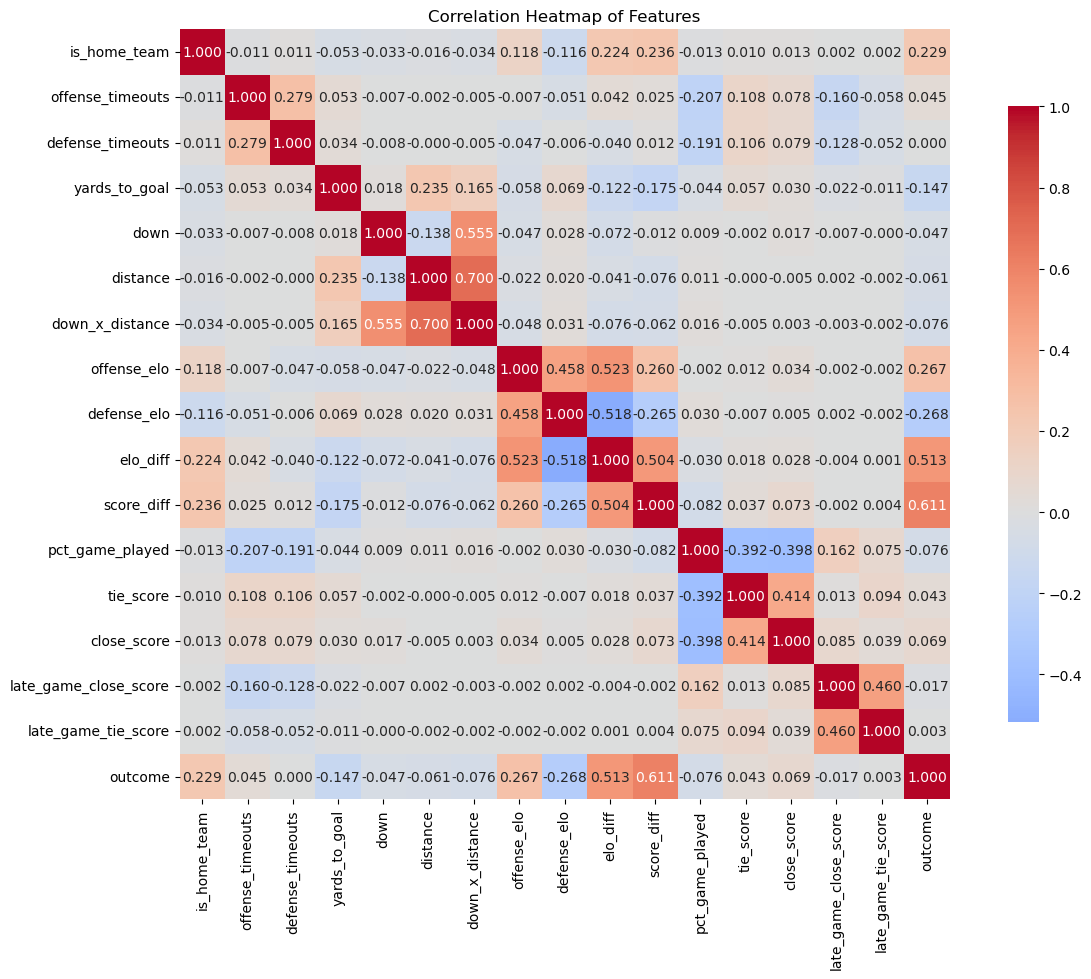

In [184]:
# correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(
    play_attempts[feature_names + [target_variable]].corr(),
    annot=True, 
    fmt=".3f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [185]:
from sklearn.utils.class_weight import compute_sample_weight
weights = {
    0: 1,
    1: 1,
    2: 1,
}
train_sample_weights = compute_sample_weight(class_weight=weights, y=train_y)
valid_sample_weights = compute_sample_weight(class_weight=weights, y=valid_y)

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

monotonic_constraints_map = {
    'is_home_team': 1,
    'offense_timeouts': 1, 
    'defense_timeouts': -1, 
    'yards_to_goal': -1,
    'down': -1,
    'distance': -1,
    'down_x_distance': -1,
    'offense_elo': 1,
    'defense_elo': -1,
    'elo_diff': 1,
    'score_diff': 1,
    'pct_game_played': 0
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# interaction_constraints_index = [
#     ['pct_game_played','score_diff'],
# ]
# interaction_constraints = tuple([
#     [feature_names.index(feature) for feature in interaction]
#     for interaction in interaction_constraints_index
# ])

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "multi:softprob",  # Changed for multiclass
        "num_class": 3,  # Added for multiclass
        "eval_metric": "mlogloss",  # Changed to multiclass logloss
        "booster": "gbtree",
        "monotonic_constraints": monotonic_constraints,
        # "interaction_constraints": interaction_constraints,
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
    
    # Calculate multiclass log loss
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y, weight=train_sample_weights)
dvalid = xgb.DMatrix(valid_x, label=valid_y, weight=valid_sample_weights)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="multiclass_optimization_wp",
    direction="minimize", 
    load_if_exists=False,
    sampler=sampler
)
study.optimize(
    lambda trial: objective(trial, dtrain, dvalid), 
    n_trials=3,
    show_progress_bar=True
)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'booster': 'gbtree',
    'monotonic_constraints': monotonic_constraints,
    # 'interaction_constraints': interaction_constraints,
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

  0%|          | 0/3 [00:00<?, ?it/s]

/Users/lukeneuendorf/miniforge3/envs/wp_sim/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:02:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "monotonic_constraints" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/lukeneuendorf/miniforge3/envs/wp_sim/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:02:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "monotonic_constraints" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/lukeneuendorf/miniforge3/envs/wp_sim/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:02:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "monotonic_constraints" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/lukeneuendorf/m

Number of boosted rounds: 37


In [186]:
from sklearn.metrics import balanced_accuracy_score, f1_score, log_loss

# Helper to compute all metrics
def evaluate_set(name, X, y_true):
    dmatrix = xgb.DMatrix(X)
    y_proba = final_model.predict(dmatrix)
    y_pred = y_proba.argmax(axis=1)

    bal_acc = balanced_accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    ce_loss = log_loss(y_true, y_proba)

    print(f"\n=== {name.upper()} SET METRICS ===")
    print(f"Balanced Accuracy : {bal_acc:.4f}")
    print(f"Macro F1 Score    : {macro_f1:.4f}")
    print(f"Log Loss          : {ce_loss:.4f}")


# Evaluate each split
evaluate_set("Train", train_x, train_y)
evaluate_set("Validation", valid_x, valid_y)
evaluate_set("Test", test_x, test_y)


=== TRAIN SET METRICS ===
Balanced Accuracy : 0.5661
Macro F1 Score    : 0.5633
Log Loss          : 0.5365

=== VALIDATION SET METRICS ===
Balanced Accuracy : 0.5550
Macro F1 Score    : 0.5425
Log Loss          : 0.5172

=== TEST SET METRICS ===
Balanced Accuracy : 0.5605
Macro F1 Score    : 0.5487
Log Loss          : 0.5001


In [187]:
from sklearn.dummy import DummyClassifier

# Fit a dummy classifier that always predicts class probabilities
dummy = DummyClassifier(strategy="prior")
dummy.fit(train_x, train_y)  # train_y should be encoded (0, 1, 2, 3)

# Evaluate on test set
dummy_probs = dummy.predict_proba(test_x)
dummy_bal_acc = balanced_accuracy_score(test_y, dummy.predict(test_x))
dummy_macro_f1 = f1_score(test_y, dummy.predict(test_x), average='macro')
dummy_ce_loss = log_loss(test_y, dummy_probs) 

print("\n=== DUMMY CLASSIFIER METRICS ===")
print(f"Balanced Accuracy : {dummy_bal_acc:.4f}")
print(f"Macro F1 Score    : {dummy_macro_f1:.4f}")
print(f"Log Loss          : {dummy_ce_loss:.4f}")


=== DUMMY CLASSIFIER METRICS ===
Balanced Accuracy : 0.3333
Macro F1 Score    : 0.2108
Log Loss          : 0.8465


In [188]:
class_probas = final_model.predict(xgb.DMatrix(play_attempts[feature_names]))
play_attempts['loss_proba'] = class_probas[:, 0]
play_attempts['tie_proba'] = class_probas[:, 1]
play_attempts['win_proba'] = class_probas[:, 2]

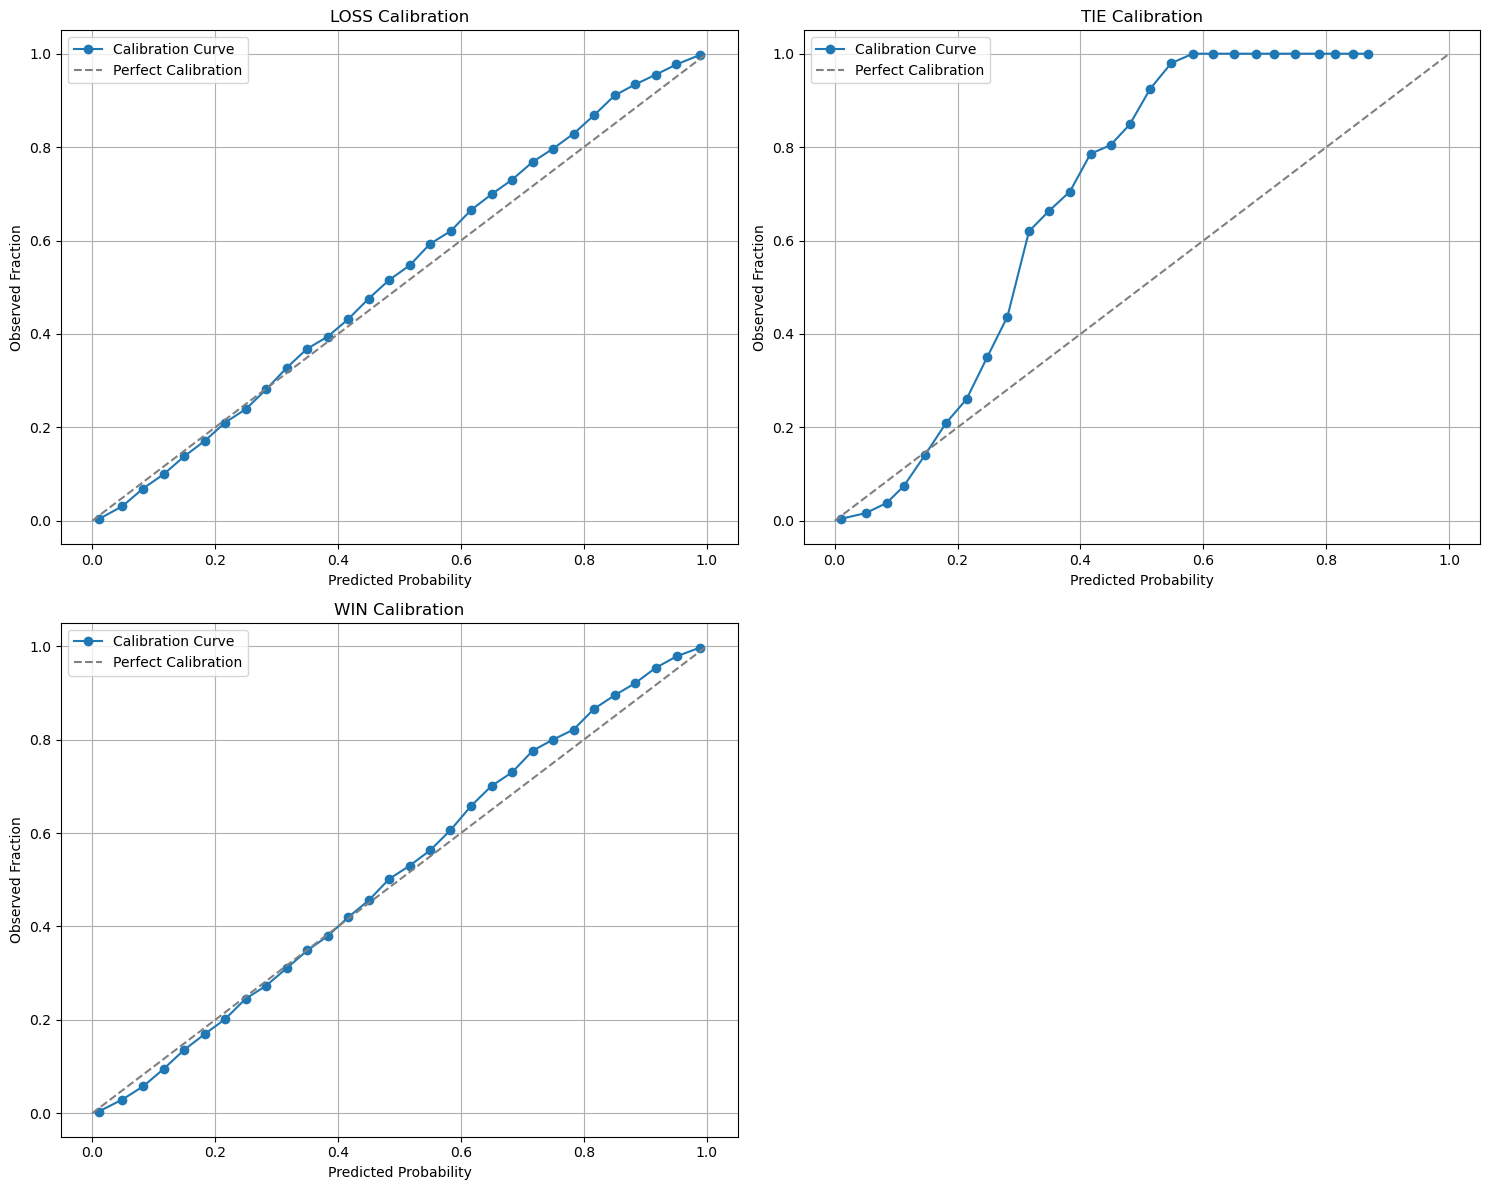

In [189]:
def plot_multiclass_calibration(df, proba_cols, actual_cols, bins=30):
    """
    Plots calibration curves for multiple classes in subplots.
    
    Args:
        df: DataFrame containing predicted probabilities and actual outcomes
        proba_cols: List of predicted probability columns (e.g., ['pass_proba', 'run_proba', ...])
        actual_cols: List of actual outcome columns (should be binary 0/1 for each class)
        bins: Number of bins for calibration
    """
    plt.figure(figsize=(15, 12))
    
    for i, (proba_col, actual_col) in enumerate(zip(proba_cols, actual_cols), 1):
        plt.subplot(2, 2, i)
        
        df['proba_bin'] = pd.cut(df[proba_col], 
                                bins=np.linspace(0, 1, bins + 1),
                                labels=False, 
                                include_lowest=True)
        
        calibration = df.groupby('proba_bin').agg(
            predicted_proba=(proba_col, 'mean'),
            actual_proba=(actual_col, 'mean'),
            count=(proba_col, 'size')
        ).reset_index()
        
        plt.plot(calibration['predicted_proba'], calibration['actual_proba'], 
                'o-', label='Calibration Curve')
        plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')
        
        plt.title(f'{proba_col.replace("_proba", "").upper()} Calibration')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Observed Fraction')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

play_attempts['loss'] = np.where(play_attempts['outcome'] == 0, 1, 0)
play_attempts['tie'] = np.where(play_attempts['outcome'] == 1, 1, 0)
play_attempts['win'] = np.where(play_attempts['outcome'] == 2, 1, 0)    

plot_multiclass_calibration(
    df=play_attempts,
    proba_cols=['loss_proba', 'tie_proba', 'win_proba'],
    actual_cols=['loss', 'tie', 'win'],
    bins=30
)

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_65194/24707366.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df.head(20), palette='viridis')


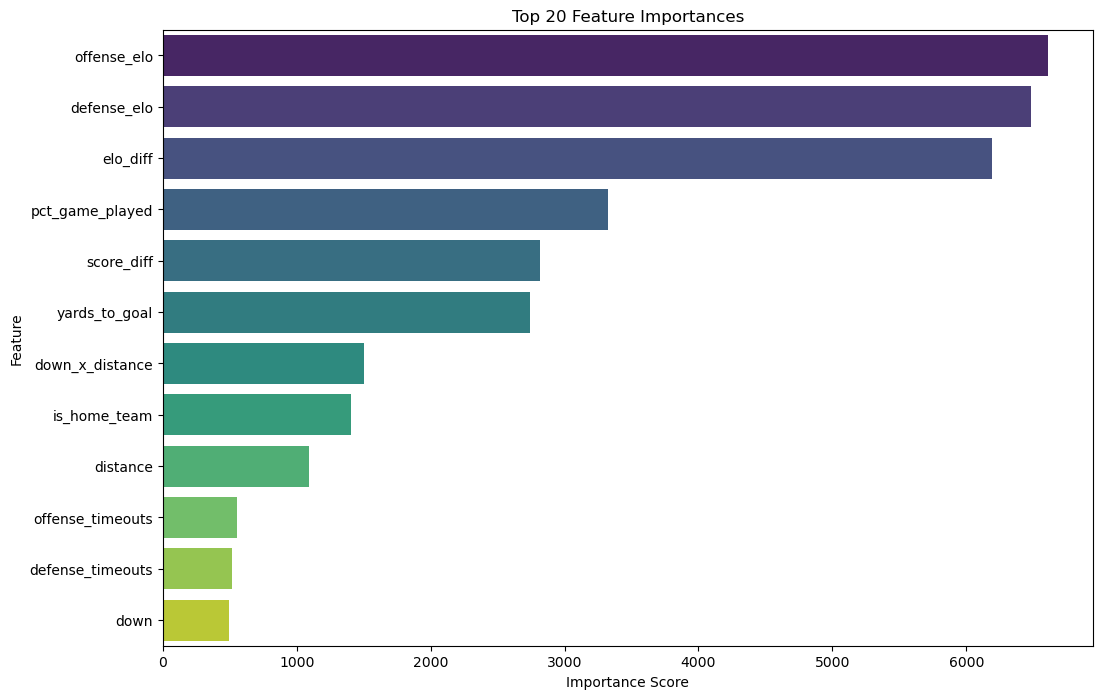

In [173]:
# feature importance
importance = final_model.get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['feature', 'importance']).sort_values(by='importance', ascending=False) 
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()